# Project Overview #
Using GANs (Generated Adversarial Network), the purpose of this project is to create images of dogs in a Kaggle competition.  Kernals are required to complete this project.  

After the data and libraries get loaded in, the model and architecture will be created in order to process all of the training data before generating images.  

This project will consist of a heavy amount of coding, so in order to assist with creating this images I will be using PyTorch.  Specifically Torchvision.  The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.

## Libraries ##

In [1]:
import os
import argparse
from time import time
import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils

## Helper Functions and Classes ##
The next set of functions are built to make the packages run smoother

In [2]:
# the following function was created in order to help make the various libraries randomly seeded in order to have more reproducibility
def seeder(seed = 301):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# configure hyperparameters by creating classes 
from dataclasses import dataclass

class Options:
    n_epochs: int = 50
    batches: int = 64
    lr: float = 0.0000000002
    b1: float = 0.1
    b2: float = 0.999
    latent_dim: int = 100
    img_size: int = 64 #image specified as 64x64
    channels: int = 3
    n_critic: int = 2
    clip_value: float = 0.01
    sample_interval: int = 10
        
opt = Options()

In [4]:
# the following class is created to help the PyTorch dataloading and make it more efficient
class Generator(Dataset):
    def __init__(self, directory, transform = None, n_samples = np.inf):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples
        
        self.samples = self._load_subfolders_images(directory)
        if not self.samples:
            raise RuntimeError("Found ) files in subfolders of: {}".format(dictionary))
            
    def subfolders_images(self, root):
        IMG_Extensions = ('.jpg', 'jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        
        def is_valid(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)
        
        required_transforms = transforms.accimageCompose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
        ])
        
        imgs = []
        for root, _, fnames in sorted(os.walk(root)):
            paths = [os.path.join(root, fname) for fname in sorted(fnames)[:min(self.n_samples, 99999999)]]
            valid_paths = filter(is_valid_file, paths)
            
            for path in valid_paths:
                img = dset.folder.default_loader(path)
                
                annotation_basename = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(dirname for dirname in os.listdir('/kaggle/input/dog-dataset/annotation') if dirname.startswith(annotation_basename.split('_')[0]))
                annotation_filename = os.path.join('/kaggle/input/dog-dataset/annotation', annotation_dirname, annotation_basename)
                tree = ET.parse(annotation_filename)
                root = tree.getroot()
                objects = root.findall('object')
                
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin, ymin, xmax, ymax = [int(bndbox.find(coord).text) for coord in ['xmin', 'ymin', 'xmax', 'ymax']]
                
                    w = np.min((xmax - xmin, ymax - ymin))
                    bbox = (xmin - 5, ymin - 5, xmin + w + 10, ymin + w + 10)
                    object_img = required_transforms(img.crop(bbox)).resize((64, 64), Image.ANTIALIAS)
                    imgs.append(object_img)
                                          
        return imgs
                                          
        def __getitem__(self, index):
            sample = self.samples[index]
            
            if self.transform is not None:
                sample = self.transform(sample)
                
            return np.asarray(sample)
                                          
        def __len__(self):
            return len(self.samples)

Another helper function will be created in order to create a data pipeline to train the neural network on a the datasets.  

In [5]:
%%time

# define the transformation for pictures
transform = transforms.Compose([
    transforms.Resize((opt.img_size, opt.img_size)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# bring in training dataset

train_data = datasets.ImageFolder(root = '/kaggle/input/dog-dataset/images', transform = transform)

# loading the data from dataloader
dataloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = opt.batches, num_workers = 4)

CPU times: user 91.1 ms, sys: 53.2 ms, total: 144 ms
Wall time: 1.4 s


The following helper function was created in order to get images from PyTorch, and arranges them into a grid.  

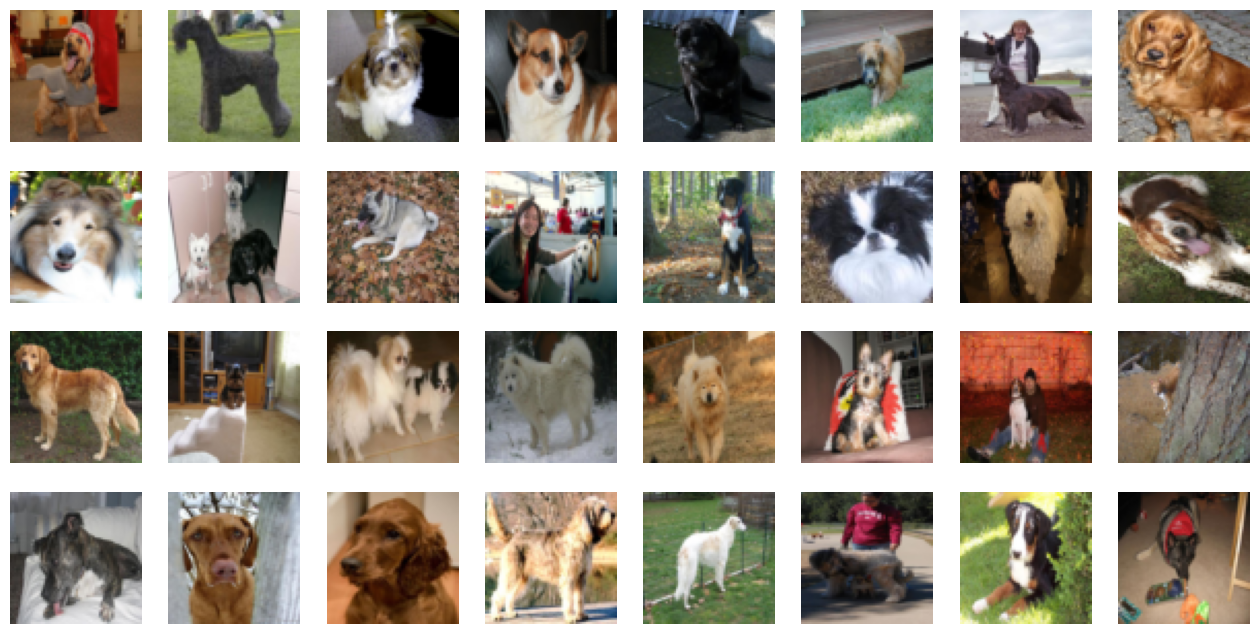

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_grid(dataloader, num_images=32, rows=4, cols=8):
    # Get a batch of images
    data_iter = iter(dataloader)
    images, _ = next(data_iter)
    
    # Ensure number of requested images is not greater than the batch size
    num_images = min(num_images, images.size(0))
    
    # Select random subset of images from the batch
    selected_indices = np.random.choice(images.size(0), num_images, replace=False)
    selected_images = images[selected_indices]
    
    # Unnormalize the images (assuming they were normalized)
    unnormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))
    selected_images = unnormalize(selected_images)
    
    # Create grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            # Convert torch tensor to numpy array and transpose the channels
            img_np = selected_images[i].numpy().transpose(1, 2, 0)
            ax.imshow(img_np)
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

# Usage example:
show_images_grid(dataloader)

Given this grid, you can see a laid out version of all these dog images that were pulled.  What's interesting to keep in mind is that there are other things in some of these photos.  Some humans, some machines etc.  

In [7]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

### Generator & Discriminator ###

Next, the generator and discriminator classes will be created in order to use later on.  

The purpose of the generator and the discriminator functions are trained at the same time.  The generator is trying to create realistic samples in order to try and 'trick' the discriminator.  The discriminator is trying to find the differences between what is real and what is not.  Due to the adversarial nature of these two, there is high quality data that gets generated.  

In [8]:
# utilize the nn package to help make a generator

class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.img_shape = img_shape

        # Define the layers of the generator
        self.fc = nn.Linear(latent_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, int(torch.prod(torch.tensor(img_shape))))

        # Tanh activation function to ensure output values are in the range [-1, 1]
        self.tanh = nn.Tanh()

    def forward(self, z):
        # Forward pass through the generator
        x = self.fc(z)
        x = nn.LeakyReLU(0.2, inplace=True)(x)
        x = self.bn1(x)
        x = self.fc2(x)
        x = nn.LeakyReLU(0.2, inplace=True)(x)
        x = self.bn2(x)
        x = self.fc3(x)
        x = nn.LeakyReLU(0.2, inplace=True)(x)
        x = self.bn3(x)
        x = self.fc4(x)
        x = nn.LeakyReLU(0.2, inplace=True)(x)
        x = self.bn4(x)
        x = self.fc5(x)
        x = self.tanh(x)
        # Reshape to the shape of the image
        img = x.view(x.size(0), *self.img_shape)
        return img

In [9]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

### Optimization ###

In order to track the losses of both the generator and discriminator during training, I created some lines of code to measure the optimization before creating the training loops.  

In [10]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# optimizer created using torch

generator = Generator(latent_dim = opt.latent_dim, img_shape = (opt.channels, opt.img_size, opt.img_size)).to(device)
discriminator = Discriminator(img_shape=(opt.channels, opt.img_size, opt.img_size)).to(device)

# loss functions
adversarial_loss = nn.BCELoss()

# create the optimizers for generator and predictor
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas = (opt.b1, opt.b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

### Training ###


[Epoch 0/50] [Batch 0/322] [D loss: 0.693877] [G loss: 0.667822]
[Epoch 0/50] [Batch 10/322] [D loss: 0.694364] [G loss: 0.667124]
[Epoch 0/50] [Batch 20/322] [D loss: 0.693208] [G loss: 0.667386]
[Epoch 0/50] [Batch 30/322] [D loss: 0.693633] [G loss: 0.667529]
[Epoch 0/50] [Batch 40/322] [D loss: 0.693477] [G loss: 0.667254]
[Epoch 0/50] [Batch 50/322] [D loss: 0.692112] [G loss: 0.667466]
[Epoch 0/50] [Batch 60/322] [D loss: 0.693213] [G loss: 0.666745]
[Epoch 0/50] [Batch 70/322] [D loss: 0.691803] [G loss: 0.667677]
[Epoch 0/50] [Batch 80/322] [D loss: 0.692938] [G loss: 0.666848]
[Epoch 0/50] [Batch 90/322] [D loss: 0.692564] [G loss: 0.666359]
[Epoch 0/50] [Batch 100/322] [D loss: 0.694370] [G loss: 0.665908]
[Epoch 0/50] [Batch 110/322] [D loss: 0.693026] [G loss: 0.665862]
[Epoch 0/50] [Batch 120/322] [D loss: 0.693601] [G loss: 0.665642]
[Epoch 0/50] [Batch 130/322] [D loss: 0.693979] [G loss: 0.667009]
[Epoch 0/50] [Batch 140/322] [D loss: 0.694045] [G loss: 0.668600]
[Epoch

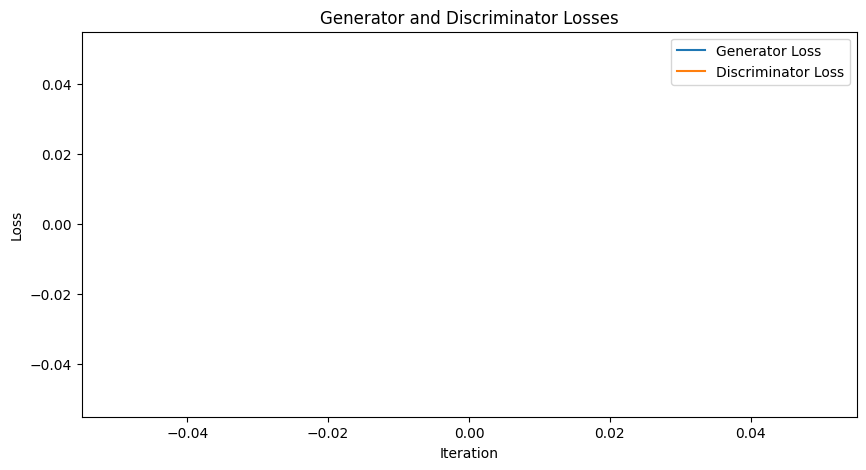

In [11]:
import matplotlib.pyplot as plt

# Lists to store generator and discriminator losses
generator_losses = []
discriminator_losses = []

# avoid tensor error
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        
        # ground truths
        valid = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad = False).to(device)
        fake = Variable(torch.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to(device)
        
        # input and optimizer
        real_imgs = Variable(imgs.type(Tensor)).to(device)
        optimizer_G.zero_grad()
        
        # create sample noises
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim)))).to(device)
        
        # image generator
        gen_imgs = generator(z)
        
        # Print shapes before passing to loss function
        #print('Shapes:')
        #print('Discriminator output shape:', discriminator(gen_imgs).shape)
        #print('Valid tensor shape:', valid.shape)
        
        # loss measure
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_D.zero_grad()
        
        # measure discriminator's ability to classify real and fake samples as well as overall discriminator loss
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # log the training statistics
        
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            

            # Plot generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses")
plt.legend()
plt.show()

### Final step creating images ###
Per the requirements of the competition, 10,000 images need to be created and saved into a zip file. 

In [12]:
import os
import torch
import torchvision.utils as vutils
import zipfile 
# Create a directory to save the generated images
os.makedirs("generated_images", exist_ok=True)

# Set the generator model to evaluation mode
generator.eval()

# Generate and save 10,000 images
num_images = 10000
batch_size = 50
num_batches = num_images // batch_size

for i in range(num_batches):
    # Generate random noise
    z = torch.randn(batch_size, opt.latent_dim, device=device)
    
    # Generate images from the noise
    with torch.no_grad():
        generated_images = generator(z).cpu()
    
    # Save the generated images
    for j in range(batch_size):
        vutils.save_image(generated_images[j], f"generated_images/image_{i * batch_size + j + 1}.png")

In [13]:
import shutil

# Zip the generated images
shutil.make_archive("images", "zip", "generated_images")

'/kaggle/working/images.zip'

### Images ###

Lets see some of the images!


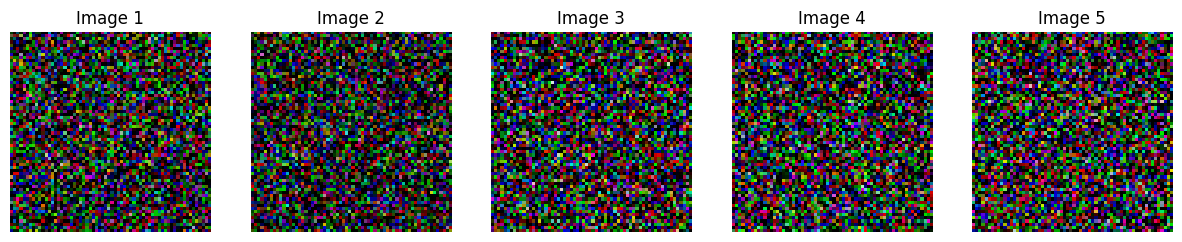

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
# Path to the zip file
zip_file_path = "/kaggle/working/images.zip"

# Directory to extract the images to
extracted_images_dir = "/kaggle/working/generated_images"

# Extract the images from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_images_dir)

# List the extracted image files
extracted_image_files = sorted(os.listdir(extracted_images_dir))

# Display the first 5 extracted images
plt.figure(figsize=(15, 6))
for i, img_file in enumerate(extracted_image_files[:5], 1):
    img_path = os.path.join(extracted_images_dir, img_file)
    img = Image.open(img_path)
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i}')
plt.show()

### Conclusions and Citations ###

Due to the time constraints in Kaggle, I was unable to diagnose exactly why there were continued issues with the images generated.  

There was, however, progress made with the discriminator and generator losses.

#### Citations ####
For help using tensorflow and GANs: https://www.tensorflow.org/tutorials/generative/dcgan

